In [1]:
from pandas import DataFrame, read_csv

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd #this is how I usually import pandas
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number

# Enable inline plotting
%matplotlib inline

In [2]:
# Read Product Demand Data

productFilePath = r'C:\Users\kumar\OneDrive\Documents\Projects\ProductDemand\data\external\productdemandforecasting\Historical Product Demand.csv'
prodDF = pd.read_csv(productFilePath)
prodDF.head(10)


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
5,Product_0979,Whse_J,Category_028,2012/4/19,500
6,Product_0979,Whse_J,Category_028,2012/6/5,500
7,Product_0979,Whse_J,Category_028,2012/6/27,500
8,Product_0979,Whse_J,Category_028,2012/7/23,500
9,Product_0979,Whse_J,Category_028,2012/8/29,500


In [3]:
# Group by products and order by count to get the max demand for a particular product

grpByProdRslt = prodDF.groupby(['Product_Code']).size().reset_index(name='counts').sort_values(['counts'],ascending=False)
grpByProdRslt.head(10)

,Product_Code,counts
1348,Product_1359,16936
1284,Product_1295,10575
1367,Product_1378,9770
619,Product_0620,9428
1275,Product_1286,8888
1371,Product_1382,8619
1442,Product_1453,8503
1283,Product_1294,8384
1366,Product_1377,7872
1276,Product_1287,7829


In [4]:
# Select Product 1359 for forecasting - high count
prod1359DF = prodDF.loc[prodDF['Product_Code'] == 'Product_1359'].sort_values(['Date'],ascending=False)
prod1359DF.describe()


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,16936,16936,16936,16936,16936
unique,1,1,1,1232,161
top,Product_1359,Whse_J,Category_019,2013/1/7,1000
freq,16936,16936,16936,35,2578


In [5]:
# Drop remaining columns
prod1359DF = prod1359DF.drop(columns=['Warehouse','Product_Code','Product_Category'])

In [ ]:


#prod1359DF.drop(prod1359DF.loc[prod1359DF['Order_Demand']=='(15000)'].index,inplace=True)

In [6]:
prod1359DF.index=pd.to_datetime(prod1359DF.Date,format='%Y/%m/%d') 
prod1359DF.drop(columns=['Date'],inplace=True)



In [7]:
prod1359DF['Order_Demand'] = prod1359DF['Order_Demand'].astype(str)
prod1359DF['Order_Demand'] = prod1359DF['Order_Demand'].map(lambda x: x.lstrip('(').rstrip(')'))
prod1359DF['Order_Demand'] = prod1359DF['Order_Demand'].astype(int)


In [8]:
#Aggregate the Date Columns by month for forecast

prod1359DmndMnth = prod1359DF.resample('M').sum()
prod1359DmndMnth.head(10)

,Order_Demand
Date,
2012-01-31,8911000
2012-02-29,8131000
2012-03-31,7775000
2012-04-30,8960000
2012-05-31,8475000
2012-06-30,6556000
2012-07-31,7422000
2012-08-31,6667000
2012-09-30,8349000


In [9]:
# Remove the last month data - Its incomplete
prod1359DmndMnth.drop(prod1359DmndMnth.loc[prod1359DmndMnth['Order_Demand']==100000].index,inplace=True)

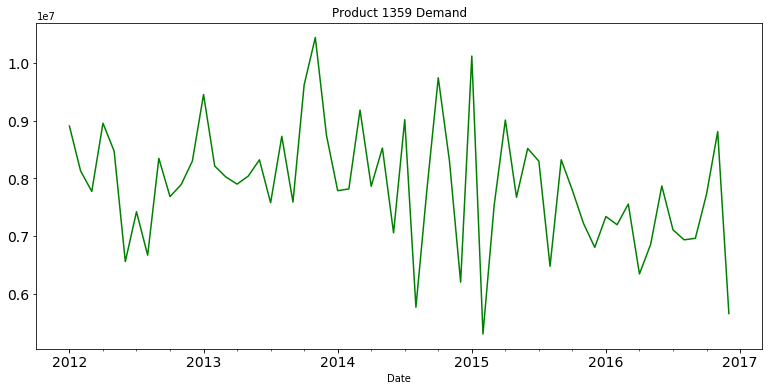

In [27]:
# Product demand for each year

prod1359DmndMnth.Order_Demand.plot(figsize=(13,6), title= 'Product 1359 Demand', fontsize=14,color="Green")
plt.show()

In [11]:
# Create Train and Test Data - Test is last 9 months

prod1359Train = prod1359DmndMnth[:'2016-03-31']
prod1359Test = prod1359DmndMnth['2016-04-30':]

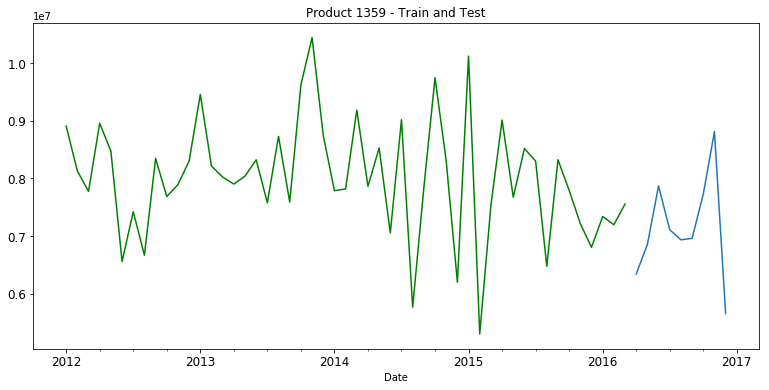

In [25]:
#Demand for product 1359
prod1359Train.Order_Demand.plot(figsize=(13,6), title= 'Product 1359 - Train and Test', fontsize=12,color="Green")
prod1359Test.Order_Demand.plot(figsize=(13,6), title= 'Product 1359 - Train and Test', fontsize=12)
plt.show()

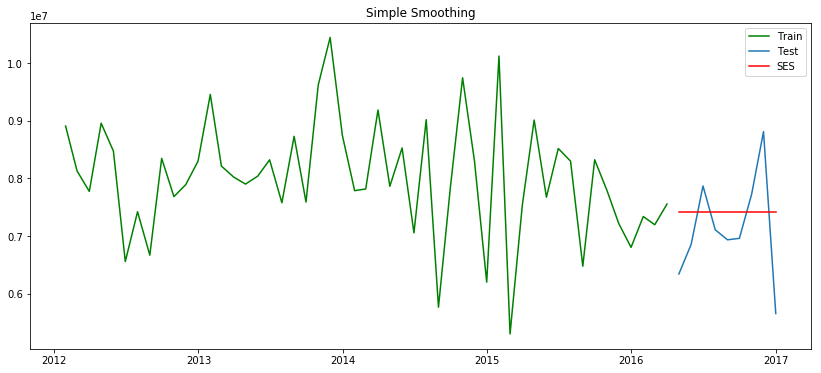

In [29]:
# Simple Smoothing

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = prod1359Test.copy()
fit2 = SimpleExpSmoothing(np.asarray(prod1359Train['Order_Demand'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(prod1359Test))
plt.figure(figsize=(14,6))
plt.plot(prod1359Train['Order_Demand'], label='Train',color="Green")
plt.plot(prod1359Test['Order_Demand'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES',color="Red")
plt.title("Simple Smoothing")
plt.legend(loc='best')
plt.show()

In [30]:
import math
from sklearn.metrics import mean_squared_error
smooth_rms = math.sqrt(mean_squared_error(prod1359Test.Order_Demand, y_hat_avg.SES))
print(smooth_rms)

905476.4628886498


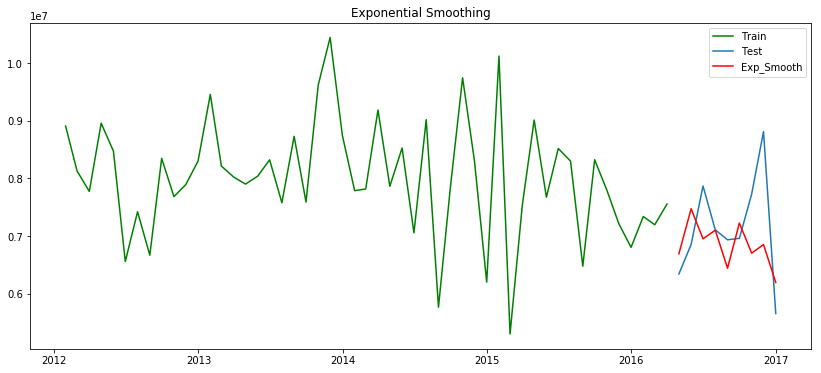

In [31]:
# Exponential Smoothing

exp_hat_avg = prod1359Test.copy()
fit1 = ExponentialSmoothing(np.asarray(prod1359Train['Order_Demand']) ,seasonal_periods=4 ,trend='additive', seasonal='additive',).fit()
exp_hat_avg['Exp_Smooth'] = fit1.forecast(len(prod1359Test))
plt.figure(figsize=(14,6))
plt.plot( prod1359Train['Order_Demand'], label='Train',color="Green")
plt.plot(prod1359Test['Order_Demand'], label='Test')
plt.plot(exp_hat_avg['Exp_Smooth'], label='Exp_Smooth',color="Red")
plt.legend(loc='best')
plt.title("Exponential Smoothing");
plt.show()

In [36]:
import math
from sklearn.metrics import mean_squared_error

exp_rms = math.sqrt(mean_squared_error(prod1359Test.Order_Demand, exp_hat_avg.Exp_Smooth))
print(exp_rms)

872760.1292784497


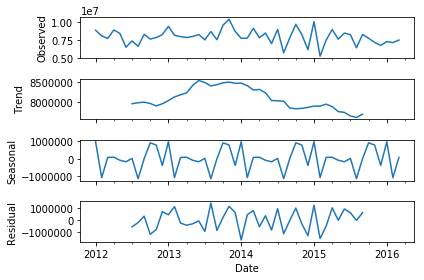

In [33]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(prod1359Train.Order_Demand).plot()
result = sm.tsa.stattools.adfuller(prod1359Train.Order_Demand)
plt.show()

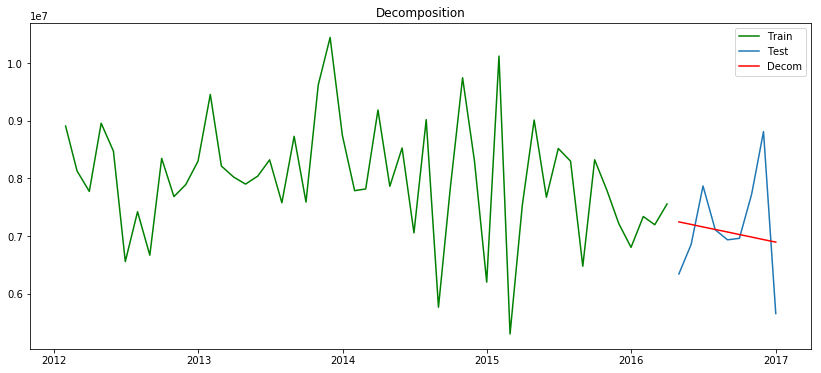

In [34]:
decom_hat_avg = prod1359Test.copy()

fit1 = Holt(np.asarray(prod1359Train['Order_Demand'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
decom_hat_avg['Decom'] = fit1.forecast(len(prod1359Test))

plt.figure(figsize=(14,6))
plt.plot(prod1359Train['Order_Demand'], label='Train',color="Green")
plt.plot(prod1359Test['Order_Demand'], label='Test')
plt.plot(decom_hat_avg['Decom'], label='Decom',color="Red")
plt.legend(loc='best')
plt.title("Decomposition");
plt.show()

In [35]:
import math
from sklearn.metrics import mean_squared_error

decom_rms = math.sqrt(mean_squared_error(prod1359Test.Order_Demand, decom_hat_avg.Decom))
print(decom_rms)

887210.9525996824


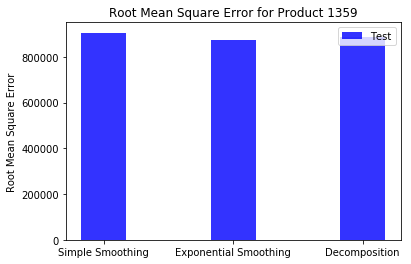

In [48]:
# Plot the Mean Square Error for Comparison
n_groups = 3
test_mse = (smooth_rms,exp_rms,decom_rms)
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
 
rects2 = plt.bar(index + bar_width, test_mse, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Test')
 
plt.ylabel('Root Mean Square Error')
plt.title('Root Mean Square Error for Product 1359')
plt.xticks(index + bar_width, ('Simple Smoothing', 'Exponential Smoothing', 'Decomposition'))
plt.legend()
